In [984]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import pandas as pd
import numpy as np
import pygeohash as pgh
from sklearn import metrics, cluster

%matplotlib inline

In [985]:
data = 'data/unit_data.csv'
df = pd.read_csv(data)
df = df[:1000]
df.head()

,id,lat,lon,size,height,width,price,rate_card_price,floor_price,cpm,impressions,unit_type,media_type,supplier_id,supplier_face_id,market
0,lamar-50251-389906,41.284430,-96.052220,"10' 6"" x 22' 9""",10.5,22.75,675.0,850.0,NaN,1.95,345364,billboard,Billboard,39,50251,OMAHA
1,lamar-50622-389944,41.210830,-95.947200,"10' 6"" x 22' 9""",10.5,22.75,675.0,810.0,NaN,4.94,136544,billboard,Billboard,39,50622,OMAHA
2,lamar-1469-566363,39.171150,-84.478510,"10' 6"" x 22' 9""",10.5,22.75,1200.0,1440.0,NaN,4.35,275720,billboard,Billboard,39,1469,CINCINNATI
3,lamar-70020-30483836,30.453580,-87.686680,"10' 6"" x 36'",10.5,36.00,1750.0,2100.0,NaN,5.64,310528,billboard,Billboard,39,70020,MOBILE-PENSACOLA
4,lamar-1967-169799,44.389385,-91.008494,14' x 48',14.0,48.00,1400.0,1680.0,NaN,3.24,432576,billboard,Billboard,39,1967,LA CROSSE-EAU CLAIRE


In [986]:
df.dtypes

id                   object
lat                 float64
lon                 float64
size                 object
height              float64
width               float64
price               float64
rate_card_price     float64
floor_price         float64
cpm                 float64
impressions           int64
unit_type            object
media_type           object
supplier_id           int64
supplier_face_id     object
market               object
dtype: object

In [987]:
df.describe()

,lat,lon,height,width,price,rate_card_price,floor_price,cpm,impressions,supplier_id
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.0,1000.000000,1.000000e+03,1000.000000
mean,37.250918,-89.400768,12.969986,30.602396,1008.369910,1228.00200,0.0,5.972790,2.867515e+05,39.223000
std,5.065976,10.945518,28.497198,26.903644,945.989991,1196.61841,NaN,6.907785,3.285720e+05,6.247103
min,25.909050,-122.885450,4.920000,10.000000,100.000000,120.00000,0.0,0.130000,1.033200e+04,28.000000
25%,33.533380,-93.588115,10.500000,22.750000,520.000000,624.00000,0.0,2.470000,1.002320e+05,39.000000
50%,37.359645,-87.020780,10.500000,22.750000,750.000000,900.00000,0.0,3.980000,1.851700e+05,39.000000
75%,41.191464,-81.498442,10.500000,36.000000,1200.000000,1440.00000,0.0,6.475000,3.293670e+05,39.000000
max,48.402698,-71.401700,576.000000,576.000000,12000.000000,14400.00000,0.0,72.790000,2.942612e+06,234.000000


In [988]:
# print(df.isnull().sum())
df.dropna(subset=['supplier_face_id', 'rate_card_price'], inplace=True)
# df.isnull().sum()

In [989]:
print(df.media_type.value_counts())
df = df[df.media_type == 'Billboard']

Billboard    1000
Name: media_type, dtype: int64


In [990]:
df.isnull().sum()

id                    0
lat                   0
lon                   0
size                  0
height                0
width                 0
price                 0
rate_card_price       0
floor_price         999
cpm                   0
impressions           0
unit_type             0
media_type            0
supplier_id           0
supplier_face_id      0
market                0
dtype: int64

In [991]:
df.height.apply(lambda h: round(h / 5))
df.width.apply(lambda w: round(w / 5))
df['sqft'] = [l[0] * l[1] for l in list(zip(df.height, df.width))]
# df['size_ratio'] = [l[0] > 0 if (l[1] / l[0]) else (l[1] / 1) for l in list(zip(df.height, df.width))]
df['size_ratio'] = [l[1] / l[0] for l in list(zip(df.height, df.width))]
# df['size_ratio'] = [l[0] for l in list(zip(df.height, df.width))]
df['geo_hash'] = [pgh.encode(l[0], l[1], precision=2) for l in list(zip(df.lat, df.lon))]
# cols = ['id', 'supplier_id', 'sqft', 'geo_hash', 'price', 'cpm', 'impressions', 'media_type']
cols = ['id', 'supplier_id', 'sqft', 'size_ratio', 'geo_hash', 'price', 'cpm', 'impressions']
orig_df = df
df = df[cols]
df.head()

,id,supplier_id,sqft,size_ratio,geo_hash,price,cpm,impressions
0,lamar-50251-389906,39,238.875,2.166667,9z,675.0,1.95,345364
1,lamar-50622-389944,39,238.875,2.166667,9z,675.0,4.94,136544
2,lamar-1469-566363,39,238.875,2.166667,dn,1200.0,4.35,275720
3,lamar-70020-30483836,39,378.000,3.428571,dj,1750.0,5.64,310528
4,lamar-1967-169799,39,672.000,3.428571,9z,1400.0,3.24,432576


In [992]:
# print(df.geo_hash.nunique())
# print(df.media_type.nunique())

# df = pd.get_dummies(df, columns=['geo_hash', 'media_type'])
# df = pd.get_dummies(df, columns=['media_type'])


In [993]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# exclude geo_hash and media_type because they are dummies now
exclude = ['id', 'supplier_id', 'lat', 'lon', 'geo_hash', 'media_type']

feature_cols = list(df.columns.difference(exclude))
orig_cols = df.columns
# don't scale the dummies
df = pd.get_dummies(df, columns=['supplier_id'])
X = scaler.fit_transform(df[feature_cols])
print(X.shape)
# scale only the feature cols, then add the dummies and combine to an array
# first array is only the feature cols, second is only the supplier id dummies
new_x = pd.concat([pd.DataFrame(X, columns=feature_cols), df[df.columns.difference(exclude)]])
new_x.dropna(axis = 0, how ='any', inplace=True)
X = new_x.to_numpy()
print(X.shape)
new_x.isnull().sum()

(1000, 5)
(1000, 10)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


cpm                0
impressions        0
price              0
size_ratio         0
sqft               0
supplier_id_234    0
supplier_id_28     0
supplier_id_36     0
supplier_id_39     0
supplier_id_60     0
dtype: int64

In [994]:
nullseries = new_x.isnull().sum()
print(nullseries[nullseries < 0])
print(X.shape)
np.where(np.isnan(X))

Series([], dtype: int64)
(1000, 10)


(array([], dtype=int64), array([], dtype=int64))

In [995]:
wcss = []
ss = []
iter_range = range(2, 16)
for i in iter_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    ss.append(metrics.silhouette_score(X, labels, metric='euclidean'))

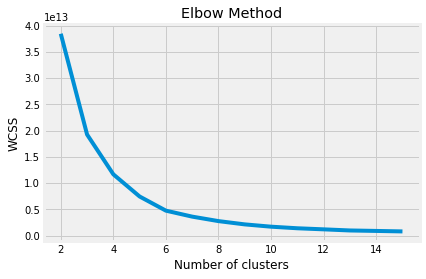

In [996]:
plt.plot(iter_range, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

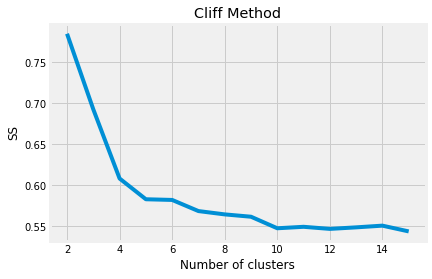

In [997]:
plt.plot(iter_range, ss)
plt.title('Cliff Method')
plt.xlabel('Number of clusters')
plt.ylabel('SS')
plt.show()

In [998]:
from sklearn.cluster import KMeans
kmeans = cluster.KMeans(n_clusters=11, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_
metrics.silhouette_score(X, labels, metric='euclidean')

0.5495546951951583

In [999]:
df['label'] = labels
# df['media_type'] = orig_df['media_type']
df.head()

,id,sqft,size_ratio,geo_hash,price,cpm,impressions,supplier_id_28,supplier_id_36,supplier_id_39,supplier_id_60,supplier_id_234,label
0,lamar-50251-389906,238.875,2.166667,9z,675.0,1.95,345364,0,0,1,0,0,6
1,lamar-50622-389944,238.875,2.166667,9z,675.0,4.94,136544,0,0,1,0,0,8
2,lamar-1469-566363,238.875,2.166667,dn,1200.0,4.35,275720,0,0,1,0,0,6
3,lamar-70020-30483836,378.000,3.428571,dj,1750.0,5.64,310528,0,0,1,0,0,6
4,lamar-1967-169799,672.000,3.428571,9z,1400.0,3.24,432576,0,0,1,0,0,9


In [1000]:
# below error means too much data
# ValueError: The number of observations must be larger than the number of variables.
# labeled_cols = ['supplier_id', 'sqft', 'geo_hash', 'price', 'cpm', 'impressions', 'media_type', 'label']
# convert media type to number
plot_cols = ['supplier_id', 'sqft', 'size_ratio', 'price', 'impressions']
# sns.pairplot(df[:1000], x_vars=plot_cols, y_vars= labeled_cols, hue='label')
print(df.columns)
df.head()
# sns.pairplot(df, x_vars=plot_cols, y_vars=plot_cols, hue='label');

Index(['id', 'sqft', 'size_ratio', 'geo_hash', 'price', 'cpm', 'impressions',
       'supplier_id_28', 'supplier_id_36', 'supplier_id_39', 'supplier_id_60',
       'supplier_id_234', 'label'],
      dtype='object')


,id,sqft,size_ratio,geo_hash,price,cpm,impressions,supplier_id_28,supplier_id_36,supplier_id_39,supplier_id_60,supplier_id_234,label
0,lamar-50251-389906,238.875,2.166667,9z,675.0,1.95,345364,0,0,1,0,0,6
1,lamar-50622-389944,238.875,2.166667,9z,675.0,4.94,136544,0,0,1,0,0,8
2,lamar-1469-566363,238.875,2.166667,dn,1200.0,4.35,275720,0,0,1,0,0,6
3,lamar-70020-30483836,378.000,3.428571,dj,1750.0,5.64,310528,0,0,1,0,0,6
4,lamar-1967-169799,672.000,3.428571,9z,1400.0,3.24,432576,0,0,1,0,0,9


In [1001]:
# df[['label', 'id', 'supplier_id', 'sqft', 'geo_hash', 'price', 'cpm', 'impressions', 'media_type']].head()
df['supplier_id'] = orig_df['supplier_id']
df['market'] = orig_df['market']
df[['label', 'id', 'supplier_id', 'sqft', 'size_ratio', 'geo_hash', 'price', 'cpm', 'impressions']].head()

,label,id,supplier_id,sqft,size_ratio,geo_hash,price,cpm,impressions
0,6,lamar-50251-389906,39,238.875,2.166667,9z,675.0,1.95,345364
1,8,lamar-50622-389944,39,238.875,2.166667,9z,675.0,4.94,136544
2,6,lamar-1469-566363,39,238.875,2.166667,dn,1200.0,4.35,275720
3,6,lamar-70020-30483836,39,378.000,3.428571,dj,1750.0,5.64,310528
4,9,lamar-1967-169799,39,672.000,3.428571,9z,1400.0,3.24,432576


In [1002]:
from sklearn.cluster import DBSCAN
print(feature_cols)
for min_sample in range(1, 20, 2):
    for eps in range(2, 10, 2):
        clustering = DBSCAN(eps=(eps/10), min_samples=min_sample).fit(df[feature_cols])
        if (np.unique(clustering.labels_)[0] != -1):
            df['cluster'] = clustering.labels_
            print(min_sample, eps)
            print(metrics.silhouette_score(df[feature_cols], df['cluster'], metric='euclidean'))

['cpm', 'impressions', 'price', 'size_ratio', 'sqft']
1 2
0.01
1 4
0.01
1 6
0.01
1 8
0.01


In [1003]:
clustering = DBSCAN(eps=.4, min_samples=1).fit(df[feature_cols])
metrics.silhouette_score(df[feature_cols], df['cluster'], metric='euclidean')

0.01

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


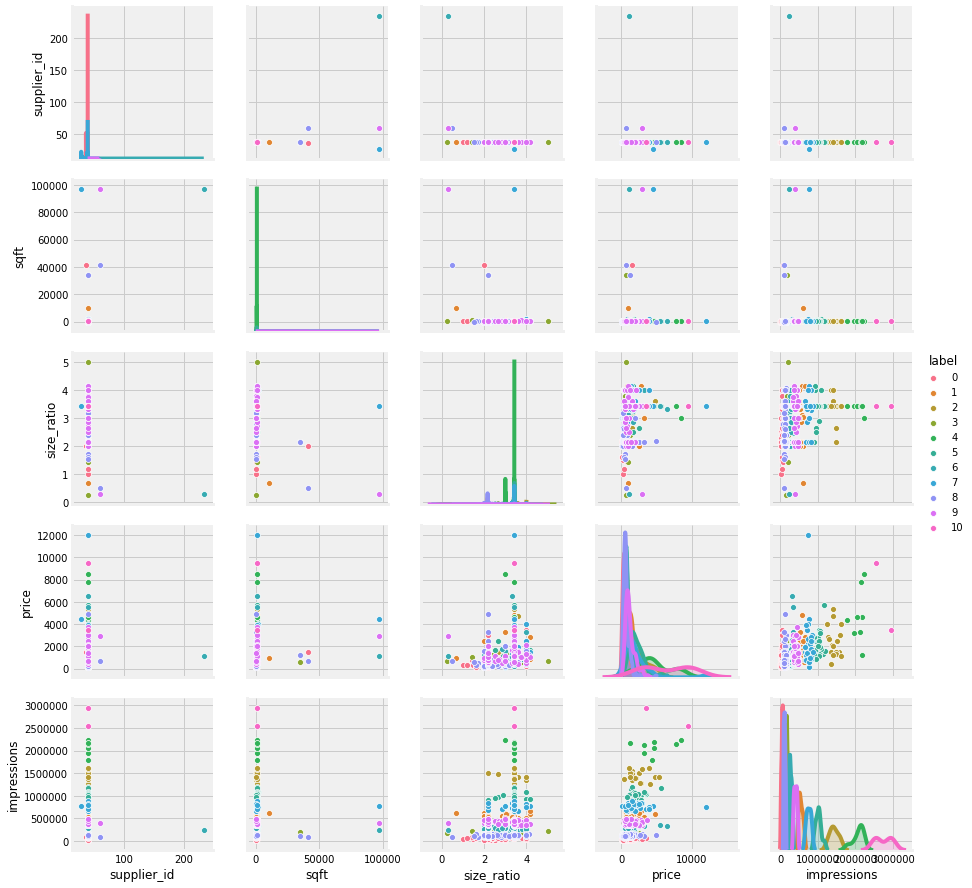

In [1004]:
plot_cols = ['supplier_id', 'sqft', 'size_ratio', 'price', 'impressions']
sns.pairplot(df, x_vars=plot_cols, y_vars=plot_cols, hue='label');

In [1005]:
df['lat'] = orig_df['lat']
df['lon'] = orig_df['lon']
df.head()

,id,sqft,size_ratio,geo_hash,price,cpm,impressions,supplier_id_28,supplier_id_36,supplier_id_39,supplier_id_60,supplier_id_234,label,supplier_id,market,cluster,lat,lon
0,lamar-50251-389906,238.875,2.166667,9z,675.0,1.95,345364,0,0,1,0,0,6,39,OMAHA,0,41.284430,-96.052220
1,lamar-50622-389944,238.875,2.166667,9z,675.0,4.94,136544,0,0,1,0,0,8,39,OMAHA,1,41.210830,-95.947200
2,lamar-1469-566363,238.875,2.166667,dn,1200.0,4.35,275720,0,0,1,0,0,6,39,CINCINNATI,2,39.171150,-84.478510
3,lamar-70020-30483836,378.000,3.428571,dj,1750.0,5.64,310528,0,0,1,0,0,6,39,MOBILE-PENSACOLA,3,30.453580,-87.686680
4,lamar-1967-169799,672.000,3.428571,9z,1400.0,3.24,432576,0,0,1,0,0,9,39,LA CROSSE-EAU CLAIRE,4,44.389385,-91.008494


In [1012]:
# chooose target
# y = df.loc[df['id'] == 229728]
# y = df.loc[df['id'] == "lamar-70020-30483836"]
y = df.loc[df['id'] == "G555158"]

                     id   sqft  size_ratio geo_hash   price   cpm  \
3  lamar-70020-30483836  378.0    3.428571       dj  1750.0  5.64   

   impressions  supplier_id_28  supplier_id_36  supplier_id_39  \
3       310528               0               0               1   

   supplier_id_60  supplier_id_234  label  supplier_id            market  \
3               0                0      6           39  MOBILE-PENSACOLA   

   cluster       lat       lon  
3        3  30.45358 -87.68668  


In [1019]:
# find all rows with the same label and/or cluster
X = df[(df['label'] == y['label'].values[0]) & (df['market'] == y['market'].values[0])]
X = X[['id', 'lat', 'lon']]
X.describe()

,lat,lon
count,6.000000,6.000000
mean,30.616472,-87.673900
std,0.213607,0.322064
min,30.453580,-88.022119
25%,30.463673,-87.942691
50%,30.502143,-87.697677
75%,30.800404,-87.401223
max,30.890293,-87.299160


In [1020]:
X.nunique()

id     6
lat    6
lon    6
dtype: int64

In [1021]:
def geo_dist(lat1, lon1, lat2, lon2):
    x = np.absolute((float(lat1)**2) - (float(lat2)**2))
    y = np.absolute((float(lon1)**2) - (float(lon2)**2))
    coord_sum = x + y
    sqrt = np.sqrt(coord_sum)
    return sqrt

In [1022]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [float(lon1), float(lat1), float(lon2), float(lat2)])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [1026]:
from geopy.distance import geodesic
output_array = []
for index1, row1 in X.iterrows():
    for index2, row2 in X.iterrows():
#         if index1 < 10:
#             print(row1['id'], y['id'].values[0])
        if (row1['id'] != y['id'].values[0]) | (row1[0] == row2[0]):
            pass
        else:
            origin = (row1['lat'], row1['lon'])  # (latitude, longitude) don't confuse
            dist = (row2['lat'], row2['lon'])
#             h_dist = haversine(row1['lon'], row1['lat'], row2['lon'], row2['lat'])
#             h_dist = geo_dist(row1[1], row1[2], row2[1], row2[2])
            h_dist = geodesic(origin, dist).kilometers
            output_array.append([row1.id, row2.id, h_dist])

In [1027]:
distance_matrix_df = pd.DataFrame(output_array, columns=['id1', 'id2', 'haversine_distance'])
distance_matrix_df.head()

,id1,id2,haversine_distance
0,lamar-70020-30483836,lamar-30132-30658330,58.039868
1,lamar-70020-30483836,lamar-15721-341689,36.600853
2,lamar-70020-30483836,lamar-13041-341433,37.227677
3,lamar-70020-30483836,lamar-30121-30658327,58.023813
4,lamar-70020-30483836,lamar-90761-406064,9.130437


In [1028]:
distance_matrix_df.sort_values(by=['haversine_distance'], ascending=True, inplace=True)

In [1029]:
distance_matrix_df[:20]

,id1,id2,haversine_distance
4,lamar-70020-30483836,lamar-90761-406064,9.130437
1,lamar-70020-30483836,lamar-15721-341689,36.600853
2,lamar-70020-30483836,lamar-13041-341433,37.227677
3,lamar-70020-30483836,lamar-30121-30658327,58.023813
0,lamar-70020-30483836,lamar-30132-30658330,58.039868
